# DNN Practical: Ag Detection by Muon Spectroscopy

In this notebook, we attempt to solve a real problem in physics using a fully connected DNN.

We have a set of spectra from Muon spectroscopy experiments, from which we would like to detect whether or not a certain element is present in a sample. In this notebook, we are going to train a neural network to detect the presence of Ag. Through this practice, we will encounter and overcome two pitfalls in deep learning, **class imbalance** and **local minima**.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# need some certainty in data processing
np.random.seed(0)

Using TensorFlow v2.3.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data'

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# The dataset

### Read raw data

The raw data, which include the constituent elements and the Muon spectra of the samples, are stored in the pickle file `muon/Ag_muon_data.pkl`. We load this file into a `pandas` dataframe and take a quick look.

In [4]:
# read data
df = pd.read_pickle(data_path + '/muon/Ag_muon_data.pkl')

# print dimensions
print('Number of samples in the dataset: %d' % len(df['Spectra']))
print('Length of spectra for each sample: %d' % len(df['Spectra'][0]))

# print the first few data
df.head(n=5)

Number of samples in the dataset: 224000
Length of spectra for each sample: 300


,Elements,Spectra
0,[Zn],"[0.0, 0.0, 181.8778921374784, 488.349654519592..."
1,"[Sb, Zn, Si]","[0.0, 0.0, 202.97108056052195, 433.59971962403..."
2,"[Fe, Sb]","[0.0, 0.0, 212.7229415490735, 428.816091507503..."
3,"[Ag, Zn, Cu, Sb]","[0.0, 0.0, 192.36172506402616, 420.19496785125..."
4,"[Fe, Zn]","[0.0, 0.0, 206.91647977543502, 434.03768636007..."


In the above table, the `Elements` and the `Spectra` columns show respectively the elements and the spectra of the samples. There are 224,000 samples in the dataset, and each spectrum is a series of 300 positive reals. 

To get a feel for the complexity of picking out signals with Ag in multinary samples, we can plot some random spectra for three representative cases: 

* no Ag
* pure Ag
* Ag-Si binary

Note that we are plotting only the first half of each spectrum. Change `[0:150]` to `[:]` to show the full spectra.

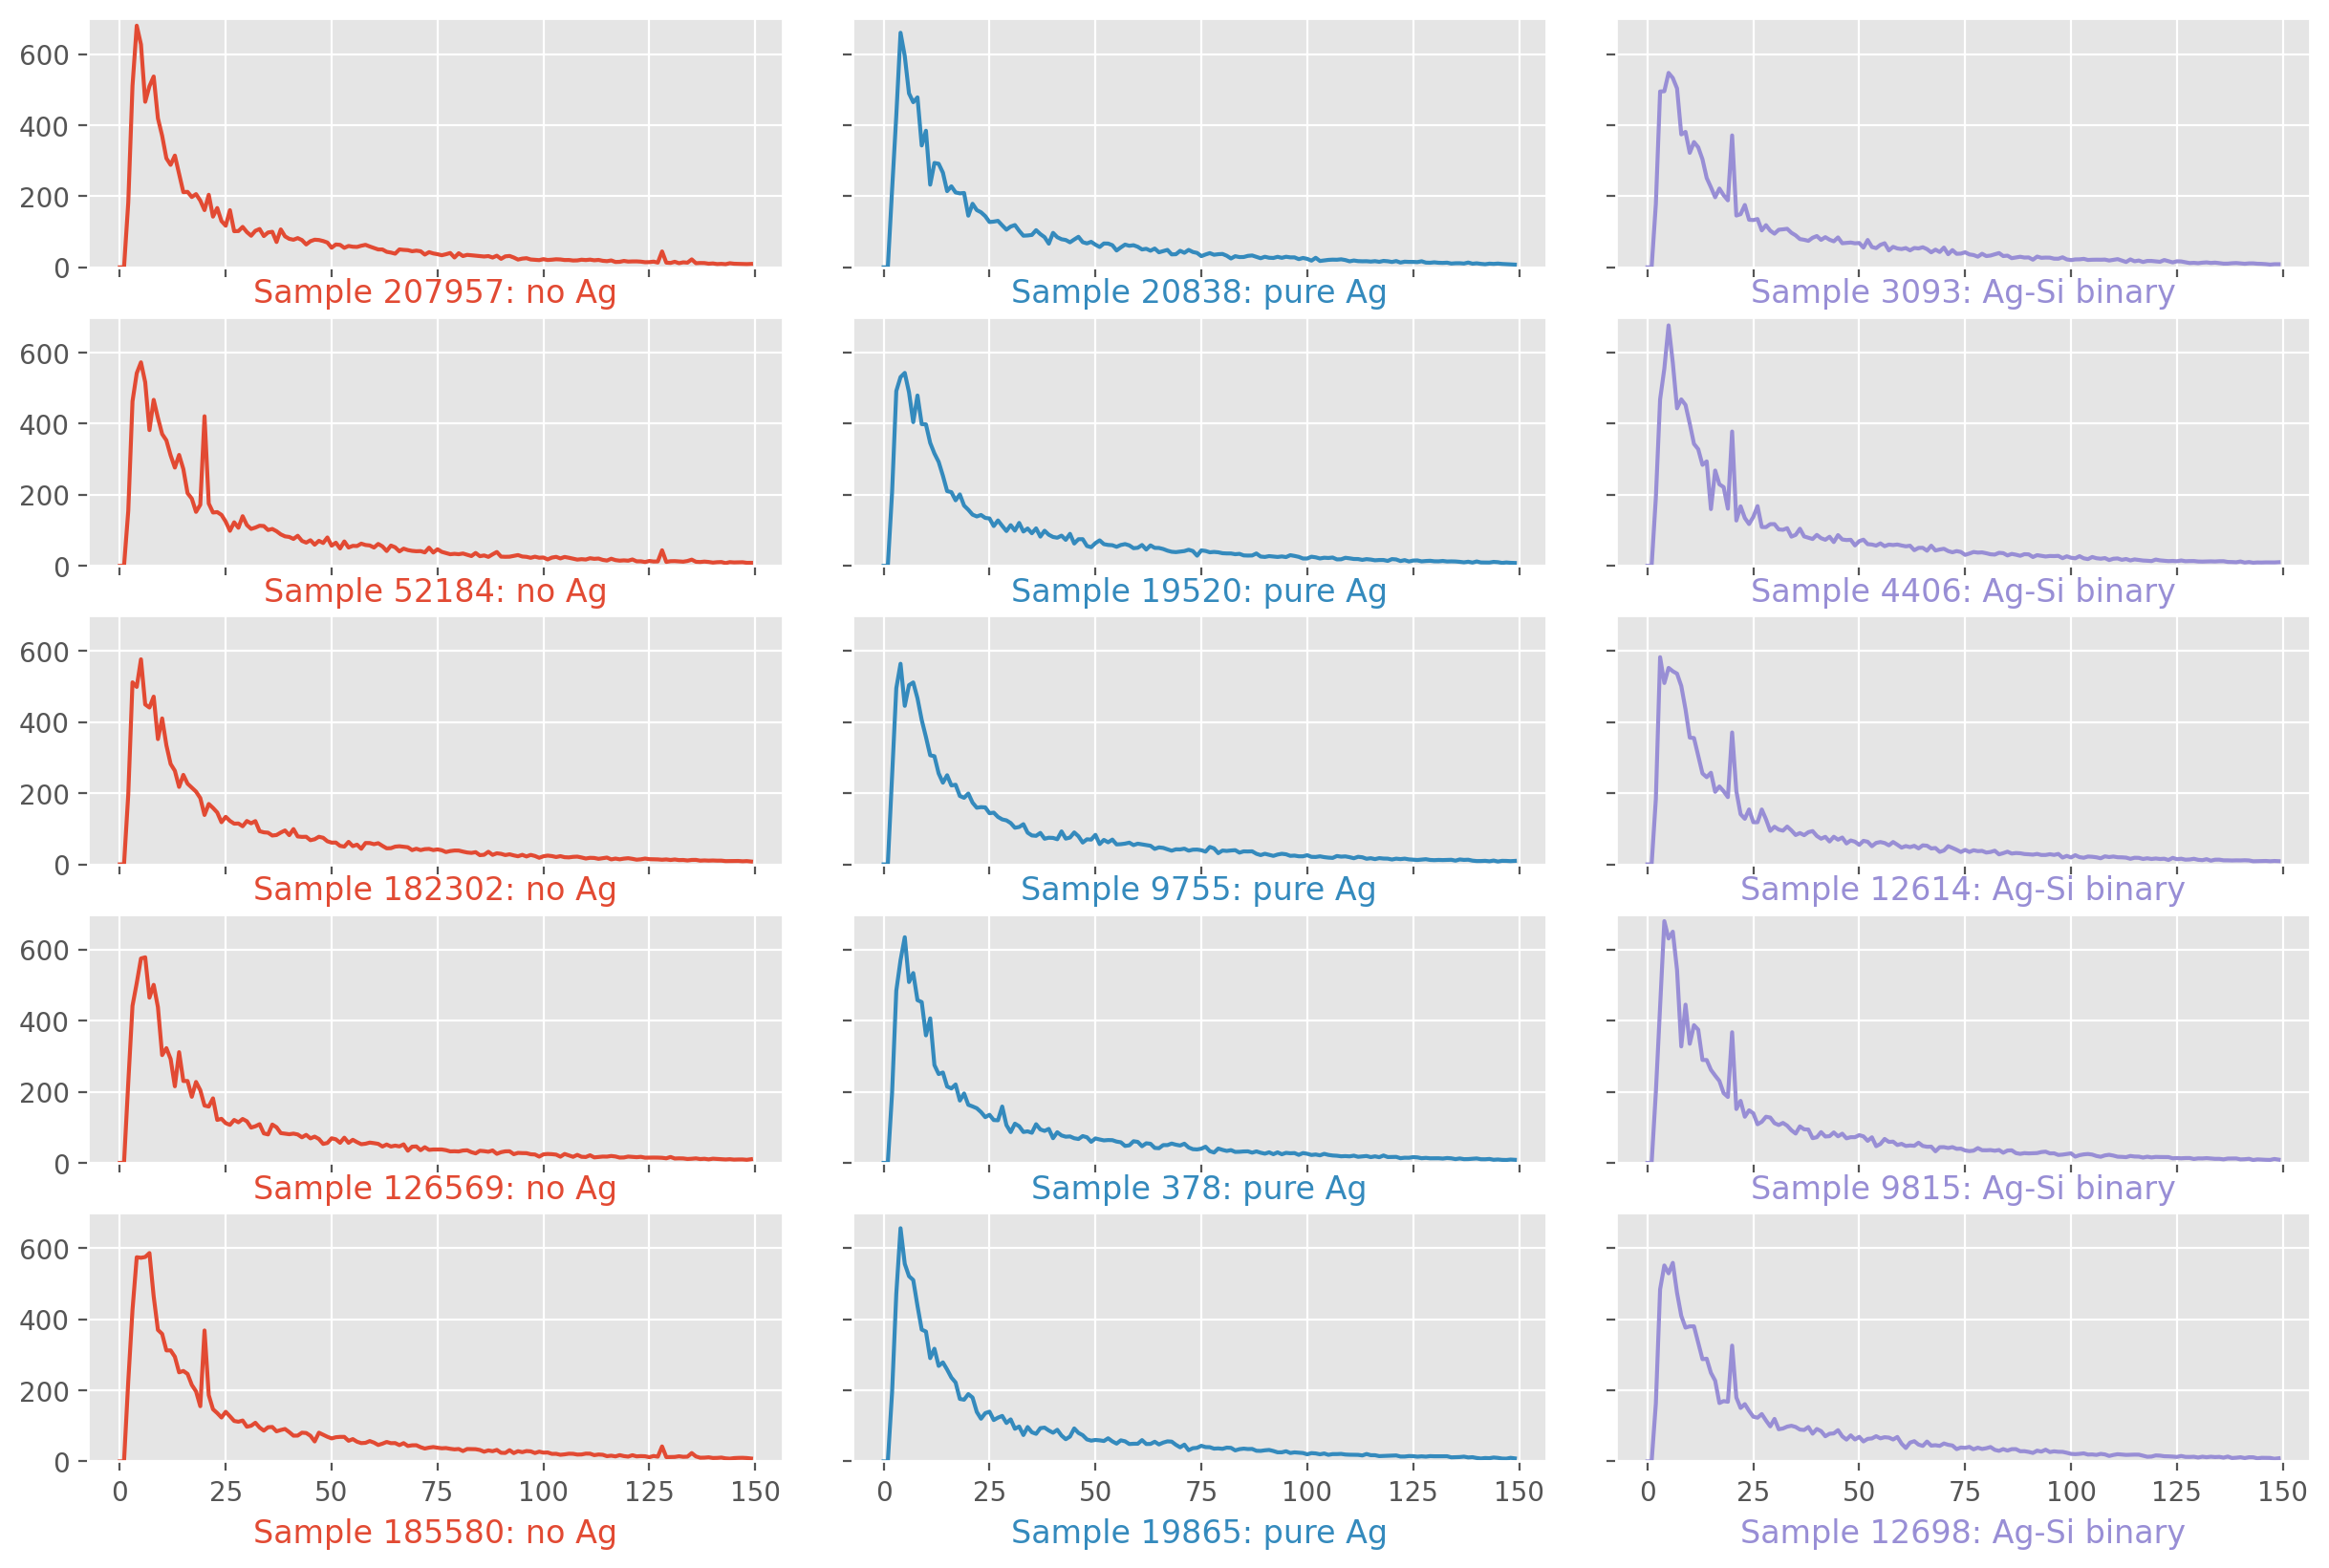

In [5]:
# conditions to select data
conditions = [
# no Ag
('no Ag', np.where(['Ag' not in elements for elements in df['Elements']])[0]),
# pure Ag
('pure Ag', np.where([['Ag'] == elements for elements in df['Elements']])[0]),
# Ag-Si
('Ag-Si binary', np.where([['Ag', 'Si'] == elements for elements in df['Elements']])[0])
]

# plot
ncond = len(conditions)
nplot = 5 # number of plots per condition
fig, axs = plt.subplots(nplot, ncond, dpi=200, figsize=(ncond * 5, nplot * 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.2)
for icond, cond in enumerate(conditions):
    for iplot, idata in enumerate(np.random.choice(cond[1], nplot)):
        axs[iplot, icond].plot(df['Spectra'][idata][0:150], c='C%d' % icond)
        axs[iplot, icond].set_xlabel('Sample %d: %s' % (idata, cond[0]), c='C%d' % icond)
        axs[iplot, icond].set_ylim(0, 700)

### Extract training data

The input data for our network will be the `Spectra` column, and we can use the `to_list()` method to convert it to a numpy array. A quick inspection over the spectra shows that the second half of each spectrum has mostly vanished and is thus uninformative; therefore, we will *only use the first half of each spectrum for training*. Such simple data preprocessing can help to reduce model scale and improve both accuracy and performance. 

The output data for our network will be a binary-valued one-hot vector: 0 for no Ag in the sample and 1 otherwise. One-hot encoding can be achieved by a simple for-loop.

In [6]:
###### input ######
# convert the 'Spectra' column to numpy
train_x = np.array(df['Spectra'].to_list())
# only take the first half for training
train_x = train_x[:, 0:150]

###### output ######
# one-hot encoding: whether Ag is in 'Elements'
train_y = np.array(['Ag' in elements for elements in df['Elements']]).astype(int)

# print data shapes
print("Shape of input: %s" % str(train_x.shape))
print("Shape of output: %s" % str(train_y.shape))

Shape of input: (224000, 150)
Shape of output: (224000,)


---

# Ag-detection by DNN

## 1. Try out a network


### Build and compile

Based on what we have learnt in [03_DNN_basics.ipynb](03_DNN_basics.ipynb), design a simple neural network with `Dense` layers to detect Ag in the spectra. In general, it is not a straightforward task to determine the number of hidden layers and the number of neurons in each layer, which usually involves some trial and error. In this case, our output size is 1, so we'd better add a small layer before it, such as one with size 8; then, between this hidden layer and the input layer (with size 150), we may add another hidden layer with size 64, approximately halfway between 8 and 150. 

Next, compile the model. We can keep using `adam` for the `optimizer` and `['accuracy']` for the `metrics`. For the `loss`, since we are fitting to a range between 0 and 1, we can choose `binary_crossentropy`.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# define the model
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```
    
</p>
</details>


In [7]:
# define the model
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                9664      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 10,193
Trainable params: 10,193
Non-trainable params: 0
_________________________________________________________________


### Train the model

Since we have not separated a subset of data for validation, we can pass `validation_split=0.2` to `model.fit()`, which then will use the *final* 20% of the dataset for validation. Let us do 20 epochs first.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# train the model
training_history = model.fit(train_x, train_y, epochs=20, batch_size=64, 
                             validation_split=0.2)
```
    
</p>
</details>

In [8]:
# train the model
training_history = model.fit(train_x, train_y, epochs=20, batch_size=64, 
                             validation_split=0.2)

Epoch 1/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.4181 - accuracy: 0.9441 - val_loss: 0.1443 - val_accuracy: 0.9990
Epoch 2/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.2059 - accuracy: 0.9518 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 3/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.1947 - accuracy: 0.9519 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 4/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.1904 - accuracy: 0.9519 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 5/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.1887 - accuracy: 0.9519 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 6/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.1875 - accuracy: 0.9519 - val_loss: 0.0448 - val_accuracy: 1.0000
Epoch 7/20
2800/2800 [==============================] - 3s 1ms/step - loss: 0.1860 - accuracy: 0.9519 - val_loss: 0.0976 - val_accuracy:

### Plot training history

For convenience, we define a function to plot a training history:

In [9]:
# a function to plot training history
def plot_history(training_history):
    # plot accuracy
    plt.figure(dpi=100, figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history[acc_str], label='Accuracy on training data')
    plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
    plt.legend()
    plt.title("Accuracy")

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Loss on training data')
    plt.plot(training_history.history['val_loss'], label='Loss on test data')
    plt.legend()
    plt.title("Loss")
    plt.show()

Now, plot the training history of the current model. They will look bizarre at this stage, as explained in the forthcoming section.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot training history
plot_history(training_history)
```
    
</p>
</details>

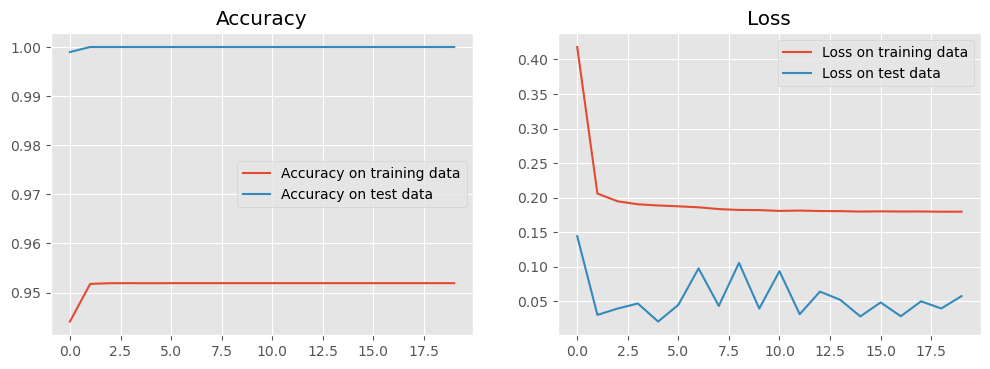

In [10]:
# plot training history
plot_history(training_history)

## 2. Class imbalance

In the above history plot, notice how the accuracy of the model quickly converges to a certain value and then stops improving completely. This value can be well above 50% (above 95% by the suggested answer), implying that the model is actually picking up something from the dataset. More strangely, the accuracy for the validation data can even be higher than that for the training data (always 100% by the suggested answer). These odd results indicate that something could be wrong within our dataset.

### Data distribution

Let us inspect the distribution of the data using `plt.hist(train_y)`, paying special attention to the validation part (the final 20%).

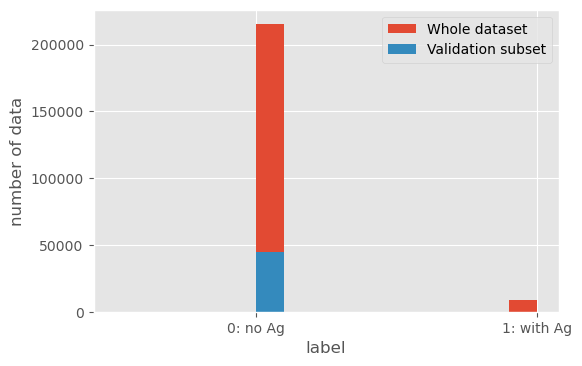

In [11]:
# plot distribution of data
plt.figure(dpi=100)
plt.hist(train_y, label='Whole dataset')
plt.hist(train_y[-len(train_y)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

The histograms show that our dataset is dominated by samples labelled 0 or "no Ag", which account for over 95% of the data. Thus, if the model simply learns to *guess* "no Ag" in every sample, it can achieve 95% accuracy (and 100% for the validation subset) without learning anything meaningful. This problem is known as **class imbalance**.

To avoid this, we must balance the classes. There are a number of strategies we can take:

* Upsample the minority class;
* Downsample the majority class;
* Change the performance metric.

The best available option for our problem is to downsample the majority class, which can be easily achieved with `numpy`:

In [12]:
# find original indices of 0 ('no Ag') and 1 ('with Ag')
id_no_Ag = np.where(train_y == 0)[0]
id_with_Ag = np.where(train_y == 1)[0]

# downsample 'no Ag' to the number of 'with Ag' by np.random.choice
id_no_Ag_downsample = np.random.choice(id_no_Ag, len(id_with_Ag))

# concatenate 'with Ag' and downsampled 'no Ag'
id_downsample = np.concatenate((id_with_Ag, id_no_Ag_downsample))

# shuffle the indices because they are ordered after concatenation
np.random.shuffle(id_downsample)

# finally get the balanced data
train_x_balanced = train_x[id_downsample]
train_y_balanced = train_y[id_downsample]

Re-exam the histograms of the balanced dataset after downsampling the majority:

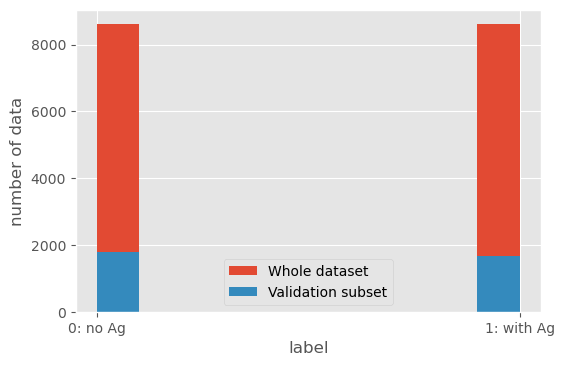

In [13]:
# plot distribution of downsampled data
plt.figure(dpi=100)
plt.hist(train_y_balanced, label='Whole dataset')
plt.hist(train_y_balanced[-len(train_y_balanced)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

### Re-train the model

Now we can re-train the model with the balanced dataset. Simply change `train_x` and `train_y` to `train_x_balanced` and `train_y_balanced` in `model.fit()` and repeat all the steps in [1. Try out a network](#1.-Try-out-a-network). Note that, to avoid the influence of the initial model state (weights and biases) left by the previous training (such as the one trained with the imbalanced dataset), we have to first re-define and re-compile the model before calling `model.fit()`. A larger `epochs` can be used because we now have much fewer data.

In the following suggested answer, we will first specify the **random seed** before building up the network. This will initialise the model parameters to reproducible random numbers so that we can address another pitfall in the next section: local minima.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# set a random seed
# 0: lead to success; model converges to the global minimum
# 1: lead to failure; model converges to a local minimum
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=200, batch_size=64, validation_split=0.2)

# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

In [14]:
# set a random seed
# 0: lead to success; model converges to the global minimum
# 1: lead to failure; model converges to a local minimum
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
216/216 [==============================] - 1s 2ms/step - loss: 3.6812 - accuracy: 0.4927 - val_loss: 2.5578 - val_accuracy: 0.4775
Epoch 2/200
216/216 [==============================] - 0s 1ms/step - loss: 2.0906 - accuracy: 0.5050 - val_loss: 1.5374 - val_accuracy: 0.5028
Epoch 3/200
216/216 [==============================] - 0s 2ms/step - loss: 1.4271 - accuracy: 0.5168 - val_loss: 1.1986 - val_accuracy: 0.5161
Epoch 4/200
216/216 [==============================] - 0s 1ms/step - loss: 1.4048 - accuracy: 0.5275 - val_loss: 0.9208 - val_accuracy: 0.5503
Epoch 5/200
216/216 [==============================] - 0s 2ms/step - loss: 1.0254 - accuracy: 0.5587 - val_loss: 1.0551 - val_accuracy: 0.5463
Epoch 6/200
216/216 [==============================] - 0s 1ms/step - loss: 0.9181 - accuracy: 0.5689 - val_loss: 0.7704 - val_accuracy: 0.5883
Epoch 7/200
216/216 [==============================] - 0s 1ms/step - loss: 0.9007 - accuracy: 0.5777 - val_loss: 0.8287 - val_accuracy: 0.5805

Epoch 58/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6812 - accuracy: 0.6228 - val_loss: 0.6368 - val_accuracy: 0.6304
Epoch 59/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6744 - accuracy: 0.6244 - val_loss: 0.7923 - val_accuracy: 0.5738
Epoch 60/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6794 - accuracy: 0.6239 - val_loss: 0.6558 - val_accuracy: 0.6234
Epoch 61/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.6320 - val_loss: 0.6322 - val_accuracy: 0.6362
Epoch 62/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6785 - accuracy: 0.6286 - val_loss: 0.6747 - val_accuracy: 0.6118
Epoch 63/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6511 - accuracy: 0.6378 - val_loss: 0.8788 - val_accuracy: 0.5228
Epoch 64/200
216/216 [==============================] - 0s 972us/step - loss: 0.6773 - accuracy: 0.6291 - val_loss: 0.6330 - val_accurac

Epoch 115/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6439 - accuracy: 0.6315 - val_loss: 0.6881 - val_accuracy: 0.5831
Epoch 116/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6283 - accuracy: 0.6436 - val_loss: 0.6282 - val_accuracy: 0.6368
Epoch 117/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6344 - accuracy: 0.6410 - val_loss: 0.6354 - val_accuracy: 0.6316
Epoch 118/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6337 - accuracy: 0.6396 - val_loss: 0.6489 - val_accuracy: 0.6211
Epoch 119/200
216/216 [==============================] - 0s 2ms/step - loss: 0.6304 - accuracy: 0.6455 - val_loss: 0.6408 - val_accuracy: 0.6211
Epoch 120/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6241 - accuracy: 0.6495 - val_loss: 0.6266 - val_accuracy: 0.6391
Epoch 121/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6293 - accuracy: 0.6466 - val_loss: 0.6306 - val_ac

216/216 [==============================] - 0s 1ms/step - loss: 0.6212 - accuracy: 0.6577 - val_loss: 0.6374 - val_accuracy: 0.6229
Epoch 172/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6277 - accuracy: 0.6497 - val_loss: 0.6297 - val_accuracy: 0.6339
Epoch 173/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6220 - accuracy: 0.6500 - val_loss: 0.6344 - val_accuracy: 0.6356
Epoch 174/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6179 - accuracy: 0.6565 - val_loss: 0.6272 - val_accuracy: 0.6371
Epoch 175/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6158 - accuracy: 0.6596 - val_loss: 0.6571 - val_accuracy: 0.6107
Epoch 176/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6225 - accuracy: 0.6550 - val_loss: 0.6303 - val_accuracy: 0.6362
Epoch 177/200
216/216 [==============================] - 0s 1ms/step - loss: 0.6211 - accuracy: 0.6588 - val_loss: 0.6316 - val_accuracy: 0.6313

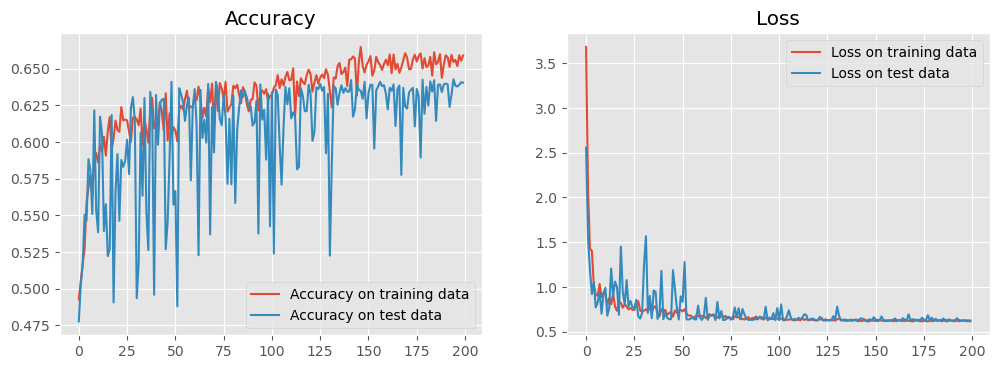

In [15]:
# plot training history
plot_history(training_history_balanced)

## 3. Local minima

Let us re-run the above cell using the suggested answer with the random seed set to 1 (also with fewer epochs):

In [16]:
# set a random seed
# 0: lead to success; model converges to the global minimum
# 1: lead to failure; model converges to a local minimum
tf.random.set_seed(1)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
216/216 [==============================] - 1s 3ms/step - loss: 2.9045 - accuracy: 0.4963 - val_loss: 0.6978 - val_accuracy: 0.5149
Epoch 2/50
216/216 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5152
Epoch 3/50
216/216 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4848
Epoch 4/50
216/216 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.4848
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4848
Epoch 6/50
216/216 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.4848
Epoch 7/50
216/216 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.4848
Epoch 

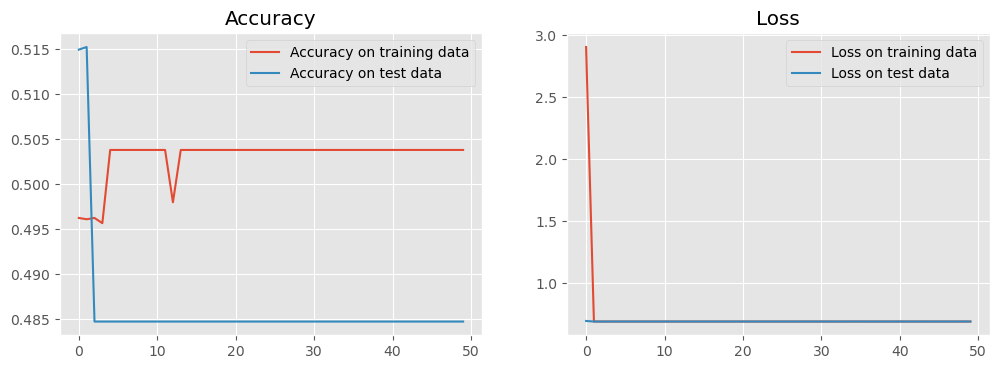

In [17]:
# plot training history
plot_history(training_history_balanced)

This time, the accuracy never improves but only oscillates around 0.5. Let us see what happens if we use this problematic model to predict:

In [18]:
# use the first 20 data for prediction
print(model.predict(train_x_balanced[0:20]))

[[0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]
 [0.5037699]]


We can see that the predicted values are close to neither 0 nor 1, but a constant number near 0.5, so the model has learnt nothing. Since we are using `sigmoid` as the activation function for the output layer, the pre-activation values of the output layer must be a constant number near 0. Therefore, we can infer that the weights and the biases are *all converging to 0* as the model trains, which is a **local minimum** of this problem. 

To avoid this local minimum, we can start from an initial state away from it.

### Model initialisation

By default, Keras initialises the weights in a `Dense` layer by random numbers sampled from the Glorot uniform distribution and the biases by zeros. Such an initial state is stochastically equivalent to the "all-zero" local minimum and thus can easily be dragged into it. 

We can avoid this local minimum by initialising the weights and the biases to be *stochastically* away from "all-zero". This can be done by passing `kernel_initializer` and `bias_initializer` to the constructor of `Dense`. For example, here we can use a normal distribution with a non-zero mean for the weights and a non-zero constant for the biases. Because such an initial state may also get further away the desired global minimum, compared to the default initial state, we will need more epochs for the model to converge.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
######## define the initializers ########
# use a normal distribution with a non-zero mean for the weights
init_weights = keras.initializers.RandomNormal(mean=0.1, stddev=0.05)
# use a non-zero constant for the biases
init_biases = keras.initializers.Ones()

# re-define the model with the initializers
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu',
                kernel_initializer=init_weights, bias_initializer=init_biases))
model.add(Dense(8, activation='relu',
                kernel_initializer=init_weights, bias_initializer=init_biases))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=64, validation_split=0.2)

# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

In [19]:
######## define the initializers ########
# use a normal distribution with a non-zero mean for the weights
init_weights = keras.initializers.RandomNormal(mean=0.1, stddev=0.05)
# use a non-zero constant for the biases
init_biases = keras.initializers.Ones()

# re-define the model with the initializers
model = Sequential()
model.add(Dense(64, input_dim=150, activation='relu',
                kernel_initializer=init_weights, bias_initializer=init_biases))
model.add(Dense(8, activation='relu',
                kernel_initializer=init_weights, bias_initializer=init_biases))
model.add(Dense(1, activation='sigmoid'))

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=64, validation_split=0.2)

Epoch 1/500
216/216 [==============================] - 0s 2ms/step - loss: 244.6306 - accuracy: 0.5040 - val_loss: 16.8399 - val_accuracy: 0.4848
Epoch 2/500
216/216 [==============================] - 0s 1ms/step - loss: 14.5384 - accuracy: 0.4984 - val_loss: 9.6114 - val_accuracy: 0.4848
Epoch 3/500
216/216 [==============================] - 0s 1ms/step - loss: 8.2491 - accuracy: 0.5131 - val_loss: 3.0070 - val_accuracy: 0.5173
Epoch 4/500
216/216 [==============================] - 0s 1ms/step - loss: 8.0902 - accuracy: 0.5138 - val_loss: 3.0129 - val_accuracy: 0.4970
Epoch 5/500
216/216 [==============================] - 0s 1ms/step - loss: 8.4333 - accuracy: 0.5074 - val_loss: 4.2875 - val_accuracy: 0.4877
Epoch 6/500
216/216 [==============================] - 0s 1ms/step - loss: 6.5044 - accuracy: 0.5211 - val_loss: 8.9225 - val_accuracy: 0.5152
Epoch 7/500
216/216 [==============================] - 0s 1ms/step - loss: 10.4205 - accuracy: 0.5059 - val_loss: 4.1834 - val_accuracy: 0

Epoch 58/500
216/216 [==============================] - 0s 1ms/step - loss: 1.0362 - accuracy: 0.5937 - val_loss: 1.0364 - val_accuracy: 0.5698
Epoch 59/500
216/216 [==============================] - 0s 1ms/step - loss: 1.1306 - accuracy: 0.5849 - val_loss: 0.9835 - val_accuracy: 0.5567
Epoch 60/500
216/216 [==============================] - 0s 1ms/step - loss: 0.9491 - accuracy: 0.5965 - val_loss: 0.7848 - val_accuracy: 0.6205
Epoch 61/500
216/216 [==============================] - 0s 1ms/step - loss: 0.9101 - accuracy: 0.5974 - val_loss: 0.8041 - val_accuracy: 0.5886
Epoch 62/500
216/216 [==============================] - 0s 1ms/step - loss: 1.1141 - accuracy: 0.5884 - val_loss: 4.5833 - val_accuracy: 0.4848
Epoch 63/500
216/216 [==============================] - 0s 1ms/step - loss: 1.0253 - accuracy: 0.5953 - val_loss: 2.2563 - val_accuracy: 0.4848
Epoch 64/500
216/216 [==============================] - 0s 1ms/step - loss: 0.9727 - accuracy: 0.6046 - val_loss: 0.9648 - val_accuracy:

Epoch 115/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6672 - accuracy: 0.6199 - val_loss: 0.6691 - val_accuracy: 0.6078
Epoch 116/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.6153 - val_loss: 0.6768 - val_accuracy: 0.6049
Epoch 117/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6897 - accuracy: 0.5993 - val_loss: 0.6345 - val_accuracy: 0.6345
Epoch 118/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6307 - val_loss: 0.7751 - val_accuracy: 0.5326
Epoch 119/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6516 - accuracy: 0.6302 - val_loss: 0.6375 - val_accuracy: 0.6298
Epoch 120/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6532 - accuracy: 0.6273 - val_loss: 0.6279 - val_accuracy: 0.6423
Epoch 121/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6499 - accuracy: 0.6332 - val_loss: 0.6933 - val_ac

216/216 [==============================] - 0s 1ms/step - loss: 0.6197 - accuracy: 0.6577 - val_loss: 0.6611 - val_accuracy: 0.6055
Epoch 172/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6247 - accuracy: 0.6531 - val_loss: 0.6558 - val_accuracy: 0.6232
Epoch 173/500
216/216 [==============================] - 0s 2ms/step - loss: 0.6232 - accuracy: 0.6540 - val_loss: 0.6260 - val_accuracy: 0.6408
Epoch 174/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6176 - accuracy: 0.6616 - val_loss: 0.6497 - val_accuracy: 0.6269
Epoch 175/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6240 - accuracy: 0.6509 - val_loss: 0.6329 - val_accuracy: 0.6356
Epoch 176/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6225 - accuracy: 0.6510 - val_loss: 0.6264 - val_accuracy: 0.6417
Epoch 177/500
216/216 [==============================] - 0s 2ms/step - loss: 0.6213 - accuracy: 0.6529 - val_loss: 0.6781 - val_accuracy: 0.5860

216/216 [==============================] - 0s 1ms/step - loss: 0.6135 - accuracy: 0.6669 - val_loss: 0.6331 - val_accuracy: 0.6345
Epoch 228/500
216/216 [==============================] - 0s 998us/step - loss: 0.6210 - accuracy: 0.6585 - val_loss: 0.6447 - val_accuracy: 0.6202
Epoch 229/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6145 - accuracy: 0.6649 - val_loss: 0.6294 - val_accuracy: 0.6365
Epoch 230/500
216/216 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.6616 - val_loss: 0.6273 - val_accuracy: 0.6400
Epoch 231/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.6582 - val_loss: 0.6247 - val_accuracy: 0.6388
Epoch 232/500
216/216 [==============================] - 0s 2ms/step - loss: 0.6128 - accuracy: 0.6649 - val_loss: 0.6340 - val_accuracy: 0.6287
Epoch 233/500
216/216 [==============================] - 0s 1ms/step - loss: 0.6184 - accuracy: 0.6584 - val_loss: 0.6265 - val_accuracy: 0.63

Epoch 283/500
216/216 [==============================] - 0s 901us/step - loss: 0.6109 - accuracy: 0.6665 - val_loss: 0.6253 - val_accuracy: 0.6388
Epoch 284/500
216/216 [==============================] - 0s 825us/step - loss: 0.6192 - accuracy: 0.6550 - val_loss: 0.6308 - val_accuracy: 0.6359
Epoch 285/500
216/216 [==============================] - 0s 919us/step - loss: 0.6144 - accuracy: 0.6651 - val_loss: 0.6314 - val_accuracy: 0.6385
Epoch 286/500
216/216 [==============================] - 0s 829us/step - loss: 0.6150 - accuracy: 0.6614 - val_loss: 0.6666 - val_accuracy: 0.5985
Epoch 287/500
216/216 [==============================] - 0s 805us/step - loss: 0.6148 - accuracy: 0.6574 - val_loss: 0.6480 - val_accuracy: 0.6211
Epoch 288/500
216/216 [==============================] - 0s 803us/step - loss: 0.6202 - accuracy: 0.6587 - val_loss: 0.6275 - val_accuracy: 0.6385
Epoch 289/500
216/216 [==============================] - 0s 821us/step - loss: 0.6153 - accuracy: 0.6635 - val_loss: 0

Epoch 339/500
216/216 [==============================] - 0s 925us/step - loss: 0.6111 - accuracy: 0.6661 - val_loss: 0.6447 - val_accuracy: 0.6307
Epoch 340/500
216/216 [==============================] - 0s 913us/step - loss: 0.6163 - accuracy: 0.6595 - val_loss: 0.6256 - val_accuracy: 0.6403
Epoch 341/500
216/216 [==============================] - 0s 906us/step - loss: 0.6125 - accuracy: 0.6649 - val_loss: 0.6294 - val_accuracy: 0.6394
Epoch 342/500
216/216 [==============================] - 0s 887us/step - loss: 0.6098 - accuracy: 0.6669 - val_loss: 0.6303 - val_accuracy: 0.6397
Epoch 343/500
216/216 [==============================] - 0s 881us/step - loss: 0.6148 - accuracy: 0.6626 - val_loss: 0.6310 - val_accuracy: 0.6385
Epoch 344/500
216/216 [==============================] - 0s 868us/step - loss: 0.6117 - accuracy: 0.6631 - val_loss: 0.6306 - val_accuracy: 0.6391
Epoch 345/500
216/216 [==============================] - 0s 896us/step - loss: 0.6103 - accuracy: 0.6663 - val_loss: 0

Epoch 395/500
216/216 [==============================] - 0s 841us/step - loss: 0.6122 - accuracy: 0.6627 - val_loss: 0.6316 - val_accuracy: 0.6365
Epoch 396/500
216/216 [==============================] - 0s 846us/step - loss: 0.6096 - accuracy: 0.6661 - val_loss: 0.6259 - val_accuracy: 0.6406
Epoch 397/500
216/216 [==============================] - 0s 847us/step - loss: 0.6151 - accuracy: 0.6634 - val_loss: 0.6274 - val_accuracy: 0.6371
Epoch 398/500
216/216 [==============================] - 0s 844us/step - loss: 0.6152 - accuracy: 0.6609 - val_loss: 0.6306 - val_accuracy: 0.6391
Epoch 399/500
216/216 [==============================] - 0s 847us/step - loss: 0.6122 - accuracy: 0.6637 - val_loss: 0.6397 - val_accuracy: 0.6342
Epoch 400/500
216/216 [==============================] - 0s 920us/step - loss: 0.6146 - accuracy: 0.6613 - val_loss: 0.6294 - val_accuracy: 0.6348
Epoch 401/500
216/216 [==============================] - 0s 870us/step - loss: 0.6112 - accuracy: 0.6663 - val_loss: 0

Epoch 451/500
216/216 [==============================] - 0s 851us/step - loss: 0.6152 - accuracy: 0.6594 - val_loss: 0.6249 - val_accuracy: 0.6414
Epoch 452/500
216/216 [==============================] - 0s 846us/step - loss: 0.6122 - accuracy: 0.6651 - val_loss: 0.6455 - val_accuracy: 0.6327
Epoch 453/500
216/216 [==============================] - 0s 923us/step - loss: 0.6139 - accuracy: 0.6624 - val_loss: 0.6243 - val_accuracy: 0.6406
Epoch 454/500
216/216 [==============================] - 0s 859us/step - loss: 0.6109 - accuracy: 0.6648 - val_loss: 0.6259 - val_accuracy: 0.6417
Epoch 455/500
216/216 [==============================] - 0s 875us/step - loss: 0.6140 - accuracy: 0.6640 - val_loss: 0.6286 - val_accuracy: 0.6385
Epoch 456/500
216/216 [==============================] - 0s 847us/step - loss: 0.6139 - accuracy: 0.6604 - val_loss: 0.6269 - val_accuracy: 0.6403
Epoch 457/500
216/216 [==============================] - 0s 822us/step - loss: 0.6129 - accuracy: 0.6673 - val_loss: 0

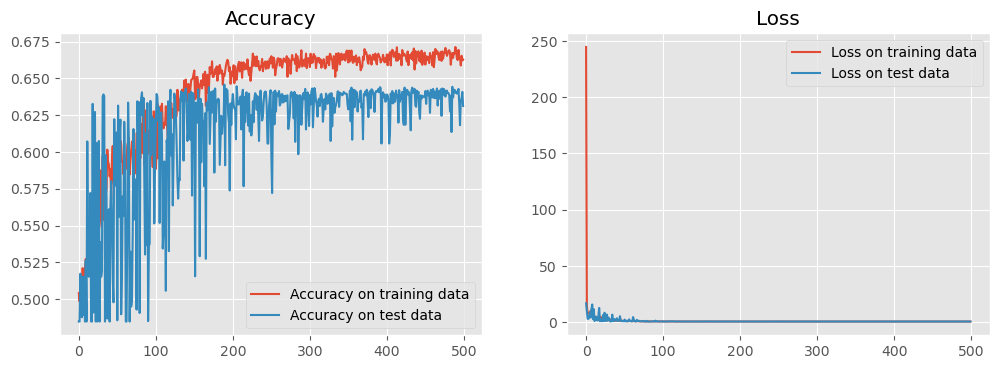

In [20]:
# plot training history
plot_history(training_history_balanced)

The history shows that our model is sightly overfitting, with the accuracy for the training data converging to 0.66 and that for the test data to 0.64. This can be alleviated by a dropout layer with a rate of 0.1 after the first hidden layer: try adding `model.add(Dropout(.1))` after `model.add(Dense(64, ...))`. Note that a larger dropout rate may again lead to the local minimum. 

---

## Exercises

Build a DNN to detect the presence of all the elements. To do this, you may go through the following steps:

1. Find all the elements appearing in the dataset; the answer will be `['Zn', 'Sb', 'Si', 'Fe', 'Ag', 'Cu', 'Bi']`.
2. Balance the dataset: if one of the elements appears much less times than the others, it is better to ignore it. Doing everything correctly, you will find the number of samples containing each element as shown in the following table. Therefore, we may ignore Ag in this network.


|  Element | # Samples |
|---|---|
|Zn| 91935|  
|Sb| 91880|  
|Si| 91672| 
|Fe| 91446|
|Ag| 8617|
|Cu| 92133|
|Bi| 91796|
    
3. Do one-hot encoding for the element list `['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']`; if a sample contains Fe and Sb, e.g., the one-hot vector for this sample will be `[0, 1, 0, 1, 0, 0]`.
4. Build and train a DNN (with an input size of 150 and an output size of 6) to detect the presence of the six elements.

Do not feel disappointed if the accuracy of the DNN turns out low, as some of the elements are physically indistinguishable from the given spectra. Nevertheless, our DNN can still mine useful information from the dataset. By comparing the predictions and the ground truth, you may notice that **only one element** is dominating the training, that is, the network can correctly predict the presence of this element while the predictions for the other elements are basically random. This indicates that the given set of spectra is characterised by this element (not considering Ag). Figure out what the element is. 
